In [1]:
import sys
import os
import ast

import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

In [2]:
# Alternative approach using explode
def expand_with_explode(df: pd.DataFrame) -> pd.DataFrame:
    # Parse the string lists
    df = df.copy()
    df['answer_choices'] = df['answer_choices'].apply(ast.literal_eval)
    df['posterior'] = df['posterior'].apply(ast.literal_eval)
    df['model'] = df['model']
    # Create separate dataframes for choices and probabilities
    choices_df = df.explode('answer_choices').rename(
        columns={'answer_choices': 'answer_choice'})
    probs_df = df.explode('posterior').rename(
        columns={'posterior': 'probability'})
    # Combine them
    result = choices_df.copy()
    result['probability'] = probs_df['probability'].values
    # Remove original columns
    result = result.drop(columns=['posterior'])
    return result

In [3]:
def expand_with_model_probs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Expand dataframe to have separate columns for each model's probabilities.
    Returns dataframe with columns: ['question_index', 'choice', 'model1_prob', 'model2_prob', ...]
    """
    df = df.copy()
    df['answer_choices'] = df['answer_choices'].apply(ast.literal_eval)
    df['posterior'] = df['posterior'].apply(ast.literal_eval)
    # Get unique models
    models = df['model'].unique()
    all_results = []
    # Process each row individually
    for _, row in df.iterrows():
        question_idx = row['question_index']
        answer_choices = row['answer_choices']
        posterior = row['posterior']
        model = row['model']
        # Create one row per choice
        for i, choice in enumerate(answer_choices):
            row_data = {
                'question_index': question_idx,
                'choice': f'{choice}_{question_idx}',
                'model': model,
                'prob': posterior[i]
            }
            all_results.append(row_data)
    # Convert to DataFrame
    result_df = pd.DataFrame(all_results)
    # Pivot to get model probabilities as columns
    pivot_df = result_df.pivot_table(
        index=['question_index', 'choice'],
        columns='model',
        values='prob',
        aggfunc='first'
    ).reset_index()
    # Rename columns to add _prob suffix
    pivot_df.columns = ['question_index', 'choice'] + [f'{col}_prob' for col in pivot_df.columns[2:]]
    return pivot_df

In [4]:
sys.path.append('model')

In [11]:
original_eval_data = pd.read_csv(
    'results/exp1/eval_metrics_tomi-first.csv')
fit_to_responses_eval_data = pd.read_csv(
    'results/exp1/eval_metrics_tomi-first_fit_to_responses.csv')

In [12]:
original_eval_data = expand_with_model_probs(original_eval_data)
fit_to_responses_eval_data = expand_with_model_probs(fit_to_responses_eval_data)

<Axes: xlabel='gpt-4o_prob', ylabel='Count'>

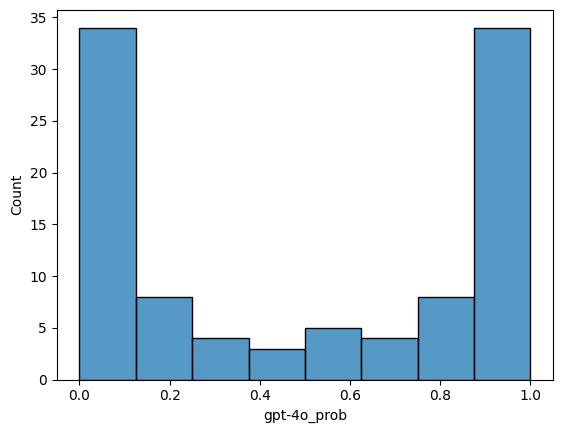

In [13]:
sns.histplot(fit_to_responses_eval_data, x='gpt-4o_prob')

<Axes: xlabel='autotom_fit_to_response_prob', ylabel='Count'>

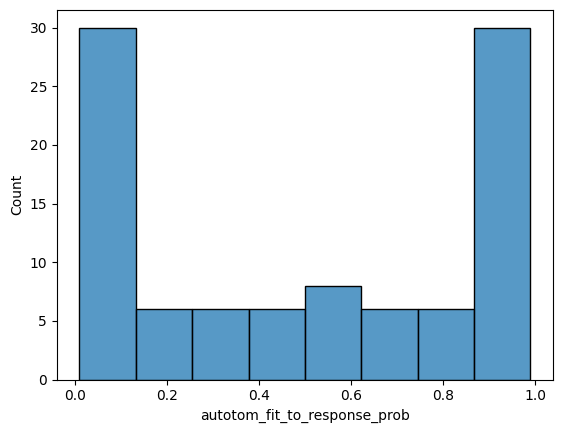

In [14]:
sns.histplot(fit_to_responses_eval_data, x='autotom_fit_to_response_prob')

In [15]:
def distance_corr_with_perm(
    x: np.ndarray,
    y: np.ndarray,
    n_perm: int = 2000,
    seed: int | None = None) -> tuple[float, float]:
    """Returns (distance_correlation, permutation_pvalue)."""
    rng = np.random.default_rng(seed)
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    try:
        # SciPy ≥ 1.10
        from scipy.stats import distance_correlation  # type: ignore[attr-defined]
        stat = float(distance_correlation(x, y))
        perms = np.array([distance_correlation(x, rng.permutation(y)) for _ in range(n_perm)], dtype=float)
    except Exception:
        # Fallback to dcor package: pip install dcor
        import dcor  # type: ignore[import-not-found]
        stat = float(dcor.distance_correlation(x, y))
        perms = np.array([dcor.distance_correlation(x, rng.permutation(y)) for _ in range(n_perm)], dtype=float)
    p_value = (np.sum(perms >= stat) + 1.0) / (n_perm + 1.0)
    return stat, p_value

def mutual_info_knn(x: np.ndarray, y: np.ndarray) -> float:
    """kNN mutual information estimate (units: nats)."""
    from sklearn.feature_selection import mutual_info_regression
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    return float(mutual_info_regression(x.reshape(-1, 1), y, random_state=0)[0])

Text(0.05, 0.95, 'dCor = 0.64\np = 0.0005')

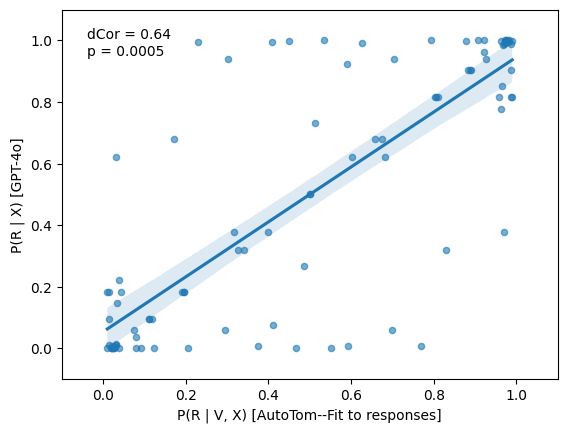

In [18]:
import numpy as np
import seaborn as sns
from matplotlib.axes import Axes

def _u_centered(D: np.ndarray) -> np.ndarray:
    m = D.mean(axis=1, keepdims=True)
    n = D.mean(axis=0, keepdims=True)
    g = D.mean()
    return D - m - n + g

def distance_correlation_np(x: np.ndarray, y: np.ndarray) -> float:
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()
    A = np.abs(x[:, None] - x[None, :])
    B = np.abs(y[:, None] - y[None, :])
    A = _u_centered(A)
    B = _u_centered(B)
    dcov2 = (A * B).mean()
    dvarx2 = (A * A).mean()
    dvary2 = (B * B).mean()
    denom = dvarx2 * dvary2
    if denom <= 0.0:
        return 0.0
    return float(dcov2 / np.sqrt(denom))

def dcor_perm(x: np.ndarray, y: np.ndarray, n_perm: int = 2000, seed: int | None = 0) -> tuple[float, float]:
    rng = np.random.default_rng(seed)
    stat = distance_correlation_np(x, y)
    perms = np.array([distance_correlation_np(x, rng.permutation(y)) for _ in range(n_perm)], dtype=float)
    p_value = (np.sum(perms >= stat) + 1.0) / (n_perm + 1.0)
    return stat, p_value

g: Axes = sns.regplot(
    x='autotom_fit_to_response_prob',
    y='gpt-4o_prob',
    data=fit_to_responses_eval_data,
    # order=2,  # uncomment for a quadratic fit if you want to show the U-shape
    scatter_kws=dict(alpha=0.6, s=20)
)
g.set_xlim(-0.1, 1.1)
g.set_ylim(-0.1, 1.1)
g.set_xlabel('P(R | V, X) [AutoTom--Fit to responses]')
g.set_ylabel('P(R | X) [GPT-4o]')

x = np.asarray(fit_to_responses_eval_data['autotom_fit_to_response_prob'])
y = np.asarray(fit_to_responses_eval_data['gpt-4o_prob'])
mask = ~np.isnan(x) & ~np.isnan(y)

if mask.sum() > 1:
    dcor, pval = dcor_perm(x[mask], y[mask], n_perm=2000, seed=0)
else:
    dcor, pval = float('nan'), float('nan')

g.text(
    0.05,
    0.95,
    f'dCor = {dcor:.2f}\np = {pval:.2g}',
    transform=g.transAxes,
    va='top',
    ha='left',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

Text(0.05, 0.95, 'dCor = 0.05\np = 0.039')

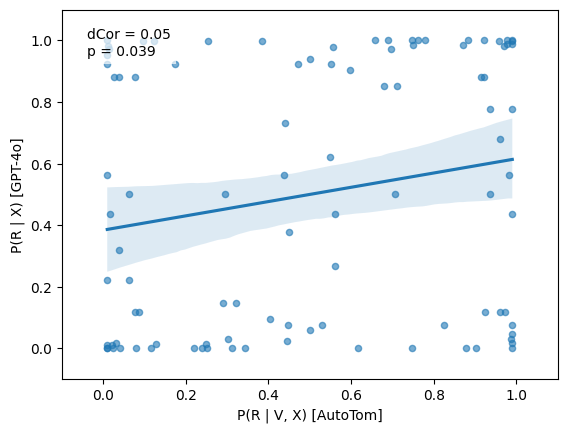

In [20]:
g: Axes = sns.regplot(
    x='autotom_prob',
    y='gpt-4o_prob',
    data=original_eval_data,
    # order=2,  # uncomment for a quadratic fit if you want to show the U-shape
    scatter_kws=dict(alpha=0.6, s=20)
)
g.set_xlim(-0.1, 1.1)
g.set_ylim(-0.1, 1.1)
g.set_xlabel('P(R | V, X) [AutoTom]')
g.set_ylabel('P(R | X) [GPT-4o]')

x = np.asarray(original_eval_data['autotom_prob'])
y = np.asarray(original_eval_data['gpt-4o_prob'])
mask = ~np.isnan(x) & ~np.isnan(y)

if mask.sum() > 1:
    dcor, pval = dcor_perm(x[mask], y[mask], n_perm=2000, seed=0)
else:
    dcor, pval = float('nan'), float('nan')

g.text(
    0.05,
    0.95,
    f'dCor = {dcor:.2f}\np = {pval:.2g}',
    transform=g.transAxes,
    va='top',
    ha='left',
    fontsize=10,
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)